# 策略梯度算法——REINFORCE

---


## 1 策略梯度算法概述

前面介绍的一系列基于价值函数的(value-based)方法，都是估计各个"状态-价值"对的未来收益的期望$Q(s,a)$，然后使用贪婪算法来选择动作。这种方法看起来并不直观，可不可以直接优化智能体的策略呢？当然可以。

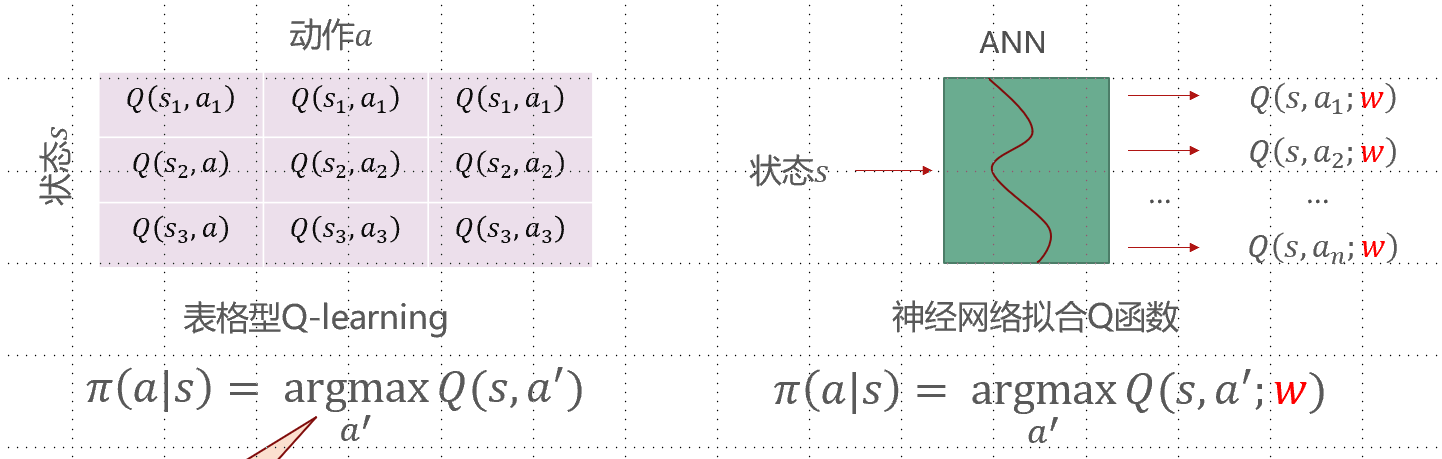

智能体的策略函数$\pi$就是从"状态"到“动作”的映射，即每给定一个状态$s$，策略函数都给出相应的动作$a=\pi(s)$。直接针对智能体的策略参数进行优化是一种更加直观自然的方式，称之为基于策略(policy-based)的方法。

以Cart-Pole为例，小车和杆子的状态为：车的位置、速度、杆子的角度、杆子末端的速度，智能体的动作为：向左、向右。智能体的任务就是不断地根据当前地状态决定向左或者向右施加力，以保持杆子不会倒下。

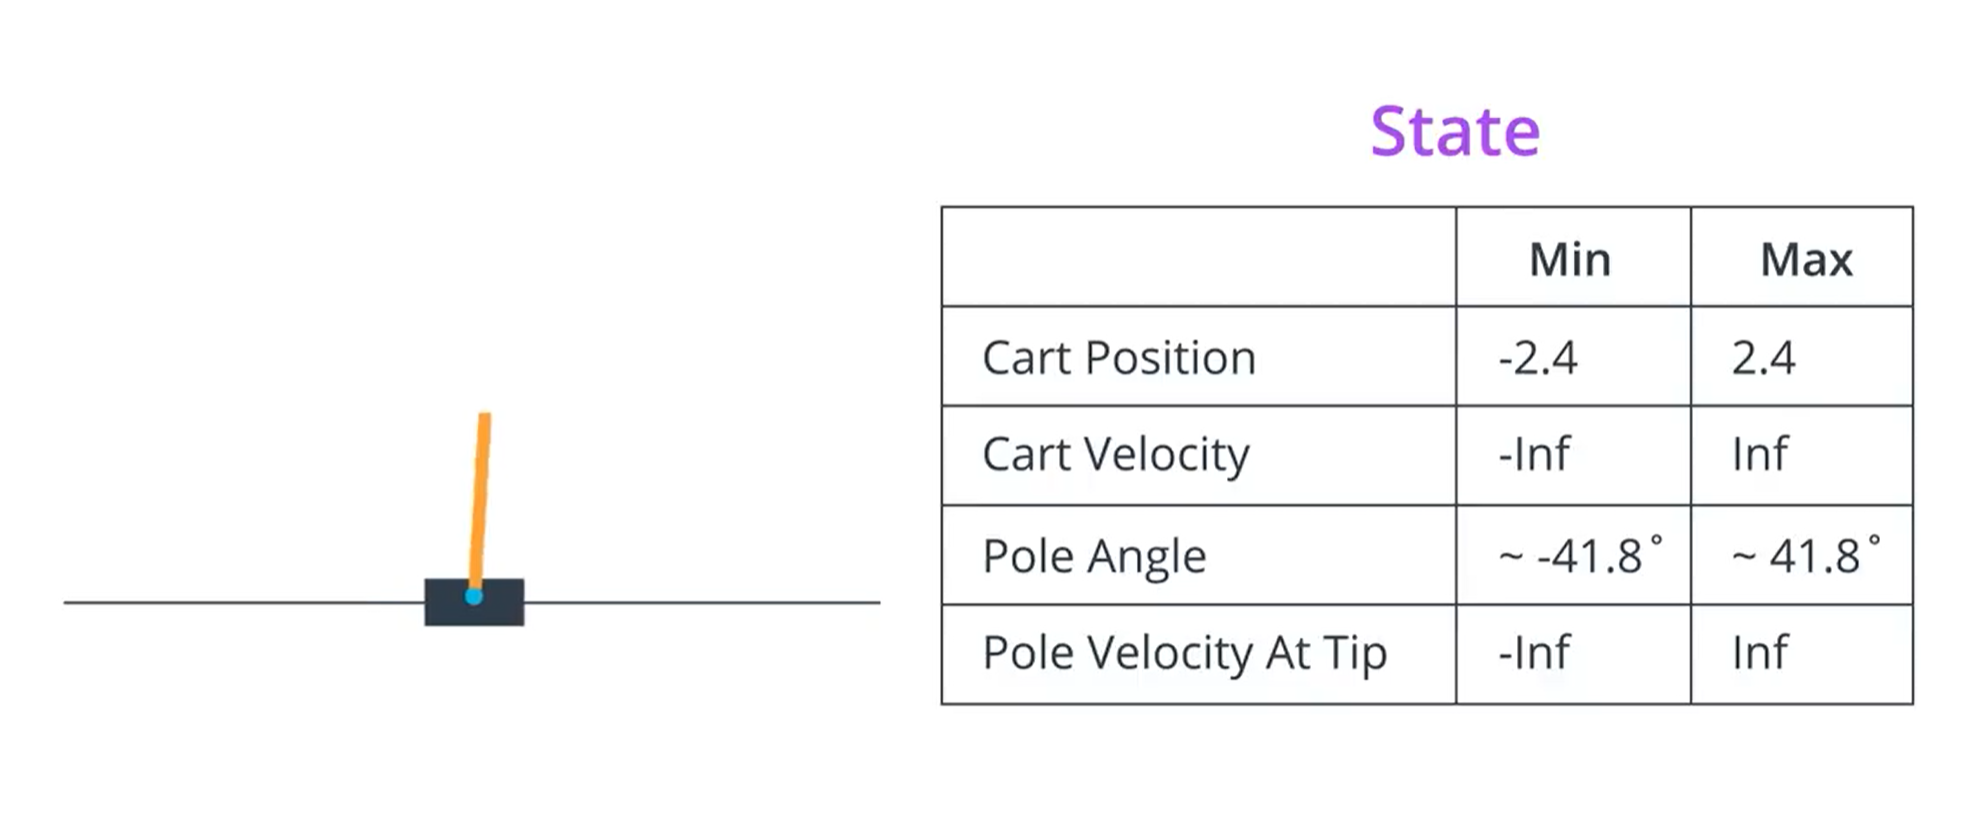

### 1.1 离散动作和连续动作对应的策略形式

<b>首先看离散动作的情况：

如果智能体的动作是离散的，策略给出每个动作被选择的概率，即随机策略$$\pi(a|s)=Pr(A=a|S=s)$$

在上面的有图中，神经网络输出了两个动作的选择概率。为了使得神经网络的输出表示各个动作的概率，一般对神经网络的输出结果使用Softmax进行处理，使输出满足概率的特性。

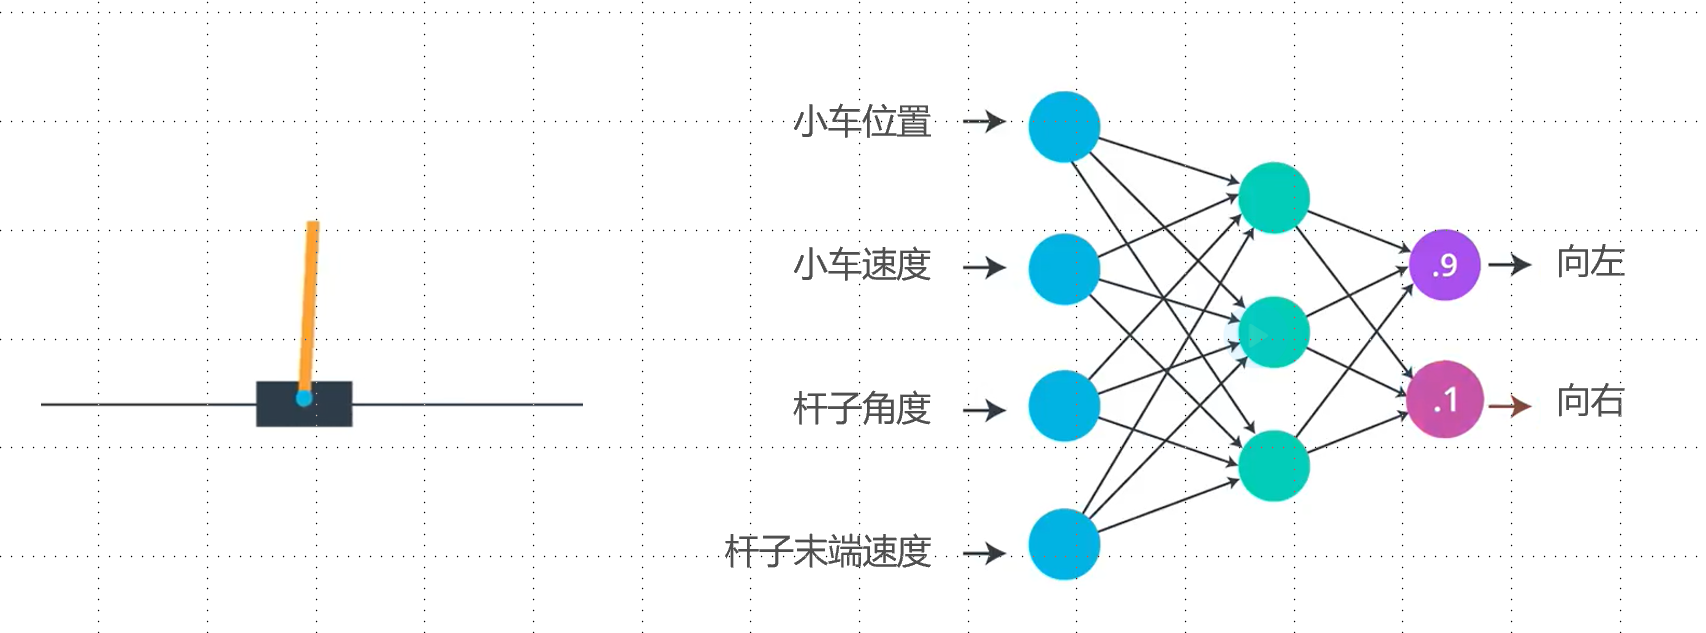

<b>再看连续动作的情况：</b>

如果智能体的动作是连续的，策略需要给出一个数。这时神经网络的输出不在表示概率，而是具体的数值。举例来说，如果Cart-Pole问题中的动作为$[-1,1]$的一个值，绝对值表示力的大小，负表示向左，正表示向右。如果想限制神经网络的输出永远是合法的，在神经网络的输出后面加上tanh这样的函数即可。当然，此时的神经网络最后一层只有一个神经元。
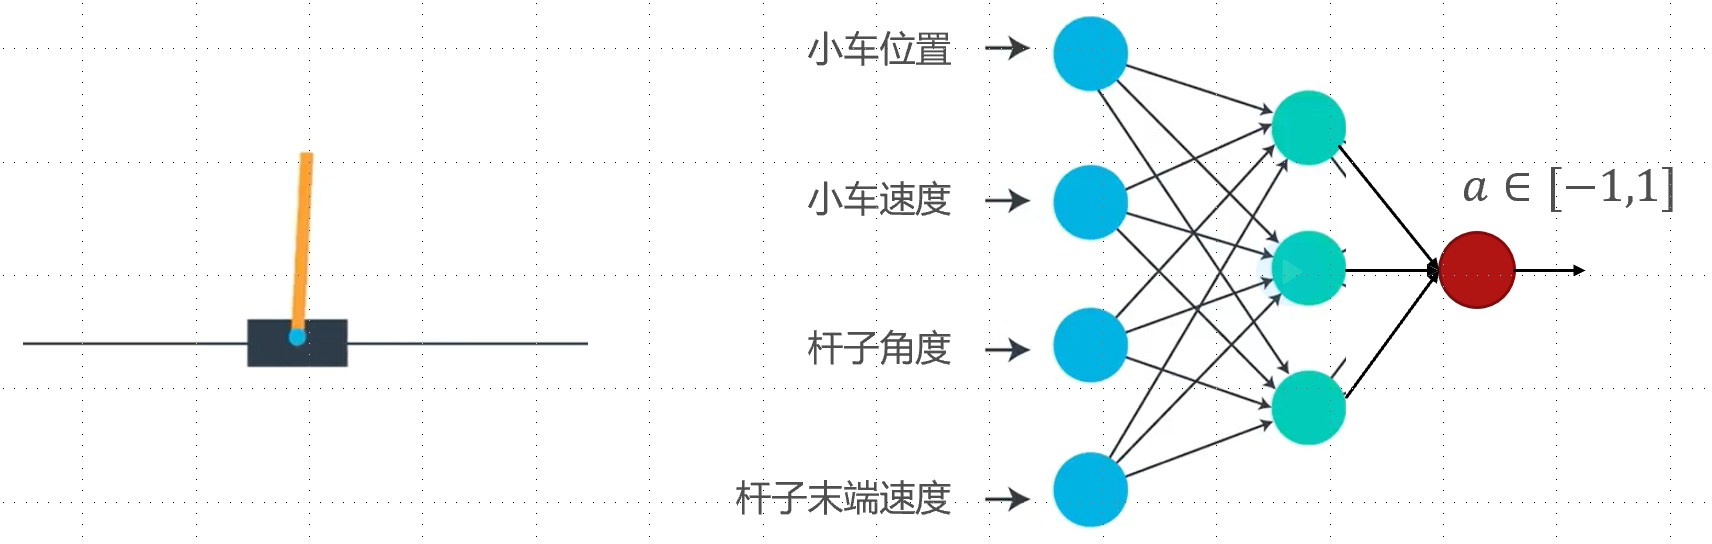

### 1.2 策略的参数及其优化

智能体的策略可以用参数化的函数实现，比如神经网络。用$\theta$表示策略的参数，则不同的参数唯一确定了智能体与环境交互的策略。为了在交互中获得更好的表现，就必须优化参数$\theta$（为了方便表述，下面直接称策略为$\theta$）。

首先，需要量化当前策略$\theta$的表现。

考虑分幕型(episodic)强化学习问题，智能体与环境交互的一条轨迹记为$$\tau=(s_0,a_0,s_1,a_1,\cdots,s_{T-1},a_{T-1},s_T)$$这一幕的回报为$$G(\tau)=r_1+r_2+\cdots+r_T$$不同的轨迹对应着不同的回报，那么当前策略$\theta$下的期望回报可以记为$$J(\theta)=\int_{\tau}p(\tau)G(\tau)d{\tau}$$其中$p(\tau)$表示轨迹$\tau$出现的概率。回到强化学习的目标，最大化长期奖励和的期望：$$\arg\max_{\theta}\mathbb{E}_\tau{J(\theta)}$$

## 2 REINCFORCE算法

### 2.1 目标函数的梯度

目标函数有了，一个很自然的想法就是使用梯度下降法优化策略$\theta$。因此首先要做的就是求出目标函数关于$\theta$的梯度。直接求导：

$$\begin{array}{*{20}{l}}{{\nabla _{\bf{\theta }}}J({\bf{\theta }})}
&{ = {\nabla _{\bf{\theta }}}\int_\tau  p (\tau)G(\tau )d\tau }\\{}
&{ = \int_\tau  {{\nabla _{\bf{\theta }}}} p(\tau )G(\tau )d\tau }\\{}
&{ = \int_\tau  p (\tau ){\nabla _{\bf{\theta }}}\log p(\tau )G(\tau )d\tau }\\{}
&{ = {\mathbb{E}_\tau }\left[ {{\nabla _{\bf{\theta }}}\log p(\tau )G(\tau )} \right]}\end{array}$$

在上面的公式推导过程中使用了几个小技巧。

> - 第1行到第2行，求导和积分交换了顺序。
> - 第2行到第3行，只需要对$p(\tau)$求导，而不需要对$G(\tau)$求导。$\theta$决定了智能体在每一步执行的动作，因而决定了整条轨迹$\tau$出现的概率$p(\tau)$。但在动作给出后，状态的转移以及这一步所获得奖励都是由环境的特性决定的，因此$G(\tau)$不是$\theta$的函数。对$p(\tau)$求导的时候，使用了对数求导的特点，即$\nabla p=p\nabla\log p$。

进一步考察$\nabla _{\theta }\log p(\tau )$，最关键的自然是$p(\tau)$，它表示整条轨迹出现的概率，和每一步的动作被选择的概率之间的关系是什么样的？因为每次做决策的时候都是独立的，因此$$\begin{array}{*{20}{l}}{p(\tau )}&{ = p({s_0},{a_0}, \cdots ,{s_{T - 1}},{a_{T - 1}},{r_T},{s_T})}\\{}&{ = p({s_0})\prod\limits_{t = 0}^{T - 1} {{\pi _{\bf{\theta }}}} ({s_t},{a_t})p({s_{t + 1}}|{s_t},{a_t})}\end{array}$$

因此$$\begin{array}{*{20}{l}}{{\nabla _{\bf{\theta }}}\log p(\tau )}&{ = {\nabla _{\bf{\theta }}}\log p({s_0})\prod\limits_{t = 0}^{T - 1} {{\pi _{\bf{\theta }}}} ({s_t},{a_t})p({s_{t + 1}}|{s_t},{a_t})}\\{}&{ = {\nabla _{\bf{\theta }}}\left[ {\log p({s_0}) + \sum\limits_{t = 0}^{T - 1} {\log {\pi _{\bf{\theta }}}} ({s_t},{a_t}) + \sum\limits_{t = 0}^{T - 1} {\log p} ({s_{T + 1}}|{s_t},{a_t})} \right]}\\{}&{ = \sum\limits_{t = 0}^{T - 1} {{\nabla _{\bf{\theta }}}} \log {\pi _{\bf{\theta }}}({s_t},{a_t})}\end{array}$$

目标函数的梯度进一步可以写成$${\nabla _{\bf{\theta }}}J({\bf{\theta }}) = {\mathbb{E}_\tau }\left[ {\sum\limits_{t = 0}^{T - 1} {{\nabla _{\bf{\theta }}}} \log {\pi _{\bf{\theta }}}({s_t},{a_t})G(\tau )} \right]$$

### 2.2 梯度的蒙特卡洛估计

经过上面的推导后，发现梯度的表达式中存在求期望的过程。将所有可能找出来然后求期望是不可能的，只能去估计期望值，而蒙特卡洛估计则是非常有效的一种估计思想。假设我们获得了$N$条智能体与环境交互的轨迹，并且每条轨迹出现的概率相等，则目标函数梯度的蒙特卡洛估计为$${\nabla _{\bf{\theta }}}J({\bf{\theta }}) = \frac{1}{N}\sum\limits_{i = 1}^N {\sum\limits_{t = 0}^{T - 1} {{\nabla _{\bf{\theta }}}} } \log {\pi _{\bf{\theta }}}(s_t^i,a_t^i)G({\tau ^i})$$

得到梯度后，使用梯度上升算法优化参数$\theta$$${\bf{\theta }} \leftarrow {\bf{\theta }} + \alpha {\nabla _{\bf{\theta }}}J({\bf{\theta }})$$

### 2.3 使用REINFORCE算法玩Cart-Pole

导入必要的python库，加载环境

In [2]:
import gym
gym.logger.set_level(40) # 减少警告输出
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(500) # 随机种子
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

env = gym.make('CartPole-v0')
env.seed(500)
print('观测空间:', env.observation_space)
print('动作空间:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

观测空间: Box(4,)
动作空间: Discrete(2)


定义策略神经网络

In [3]:
class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)  # 这个m里面应该包含了概率以及概率的对数
        action = m.sample()
        return action.item(), m.log_prob(action) 

使用REINFORCE算法训练策略网络

In [4]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=2000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        #  generate a trajectory
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards))]
        G = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:            
            policy_loss.append(-log_prob * G) # 最大化目标，使用梯度下降，因此在目标前加负号
            
        policy_loss = torch.cat(policy_loss).sum() # 这个就是目标函数
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'
                  .format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'
                  .format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce()

Episode 100	Average Score: 31.32
Episode 200	Average Score: 52.96
Episode 300	Average Score: 90.69
Episode 400	Average Score: 168.04
Episode 500	Average Score: 176.96
Environment solved in 461 episodes!	Average Score: 195.63


画训练曲线

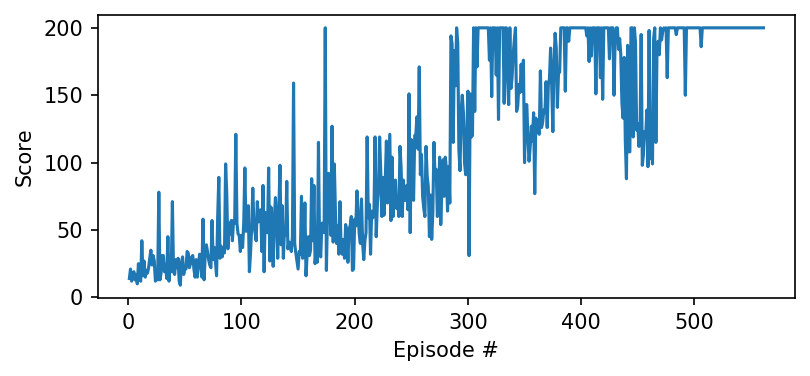

In [5]:
fig = plt.figure(figsize=(6,2.5),dpi=150)
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

可视化训练后的智能体体环境交互情况

In [ ]:
env = gym.make('CartPole-v0')

state = env.reset()
for t in range(1000000000):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        state = env.reset()

env.close()